In [50]:
import numpy as np
import pandas as pd
import glob
import math
import os 
from random import shuffle
import cv2
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

In [51]:
sampling_rate = 2048
gesture_size = 3072 #each gesture records 1.5 seconds
time_ms = (1/sampling_rate) * 1000 #sampling time in ms
nfft = 128 #window length -> 256 samples - 125 ms and 128 samples - 62.5ms
overlap = 112 #87.5% overlapping [128 - 112ms and 256 - 224ms]
zp =  0
T_sample = 1.5 #in seconds

data = []
IMAGE_WIDTH = 288
IMAGE_HEIGHT = 432

gesture_mapping = {'tick': 3,
                    'front_and_back': 2,
                    'up_and_down': 1,
                    'nothing': 0
                   }

In [52]:
path = r'D:\Education\TUM\master_thesis\data\sf2048_3072_1_5s\subset_pictures'                   
image_paths = os.listdir(path)
shuffle(image_paths)
print(image_paths)

['tick-3.png', 'tick-7.png', 'nothing-8.png', 'nothing-1.png', 'up_and_down-5.png', 'up_and_down-4.png', 'front_and_back-2.png', 'front_and_back-5.png', 'tick-2.png', 'front_and_back-9.png', 'up_and_down-2.png', 'front_and_back-4.png', 'front_and_back-6.png', 'up_and_down-9.png', 'front_and_back-3.png', 'nothing-6.png', 'tick-10.png', 'up_and_down-1.png', 'up_and_down-7.png', 'nothing-3.png', 'nothing-2.png', 'tick-9.png', 'nothing-4.png', 'up_and_down-3.png', 'tick-6.png', 'up_and_down-8.png', 'front_and_back-1.png', 'front_and_back-8.png', 'up_and_down-10.png', 'tick-8.png', 'up_and_down-6.png', 'tick-5.png', 'nothing-7.png', 'front_and_back-10.png', 'front_and_back-7.png', 'tick-1.png', 'nothing-9.png', 'tick-4.png', 'nothing-10.png', 'nothing-5.png']


In [53]:
def label_int(word_label):
    label = gesture_mapping[word_label]
    label_arr = np.zeros(4)
    label_arr[label] = 1
    return label_arr

In [54]:
for img in image_paths:
    word_label = img.split('-')[0]
    label = label_int(word_label)
    img_path = os.path.join(path, img)
    image = cv2.imread(img_path)
    #image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype('float') / 255.0
    data.append([image, label])
       

In [55]:
#parameters
data_size = len(data)
input_shape = image.shape  
split_ratio = 0.8
train_size = int(data_size * split_ratio)
BATCH_SIZE = 4
EPOCHS = 50
NUM_CLASSES = 4
LEARNING_RATE = 1e-4
MOMENTUM = 0.8
DECAY = 1e-06

print("total number of images = " + str(data_size))
print("input image shape = " + str(input_shape))

train_data = data[:train_size]
train_images = np.array([i[0] for i in train_data])
#.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
train_labels = np.array([i[1] for i in train_data])

test_data = data[train_size:]
X_test = np.array([i[0] for i in test_data])
#.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
Y_test = np.array([i[1] for i in test_data])

X_train, X_val, Y_train, Y_val = train_test_split(train_images, 
                                                  train_labels, 
                                                  test_size=0.15, 
                                                  stratify=np.array(train_labels), 
                                                  random_state=42)


print ("number of training + validation examples = " + str(train_images.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


total number of images = 40
input image shape = (288, 432, 3)
number of training + validation examples = 32
number of test examples = 8
X_train shape: (27, 288, 432, 3)
Y_train shape: (27, 4)
X_val shape: (5, 288, 432, 3)
Y_val shape: (5, 4)
X_test shape: (8, 288, 432, 3)
Y_test shape: (8, 4)


[0. 1. 0. 0.]


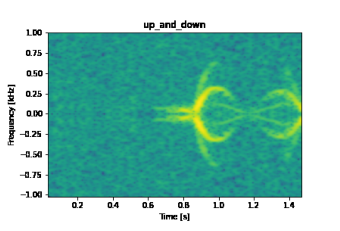

In [56]:
#plt.imshow(data[15][0])
#plt.axis('off')
#print(data[15][1])


plt.imshow(X_train[0])
plt.axis('off')
print(Y_train[0])


In [57]:
def get_model():
    model = tf.keras.Sequential()#Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=input_shape))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(BatchNormalization())
    
    
    model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.2)) 
    
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    #model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(4, activation = 'softmax'))
    
    sgd = tf.keras.optimizers.SGD(lr=LEARNING_RATE, decay=DECAY, momentum=MOMENTUM, nesterov=True)
    adam = tf.keras.optimizers.Adam(lr=LEARNING_RATE, decay = DECAY)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])
    print('model prepared...')
    return model

In [58]:
model = get_model()

model prepared...


In [59]:
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1, validation_data=(X_test,Y_test))

Epoch 1/50
5/7 [====================>.........] - ETA: 1:20 - loss: 3.9368 - accuracy: 0.2967

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "d:\education\tum\master_thesis\tum_git_project\my_env\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-59-efca905cbb04>", line 1, in <module>
    history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1, validation_data=(X_test,Y_test))
  File "d:\education\tum\master_thesis\tum_git_project\my_env\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1100, in fit
    tmp_logs = self.train_function(iterator)
  File "d:\education\tum\master_thesis\tum_git_project\my_env\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "d:\education\tum\master_thesis\tum_git_project\my_env\lib\site-packages\tensorflow\python\eager\def_function.py", line 855, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-c

TypeError: object of type 'NoneType' has no len()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
predictions = model.evaluate(X_train, Y_train)
print ("Loss = " + str(predictions[0]))
print ("Test Accuracy = " + str(predictions[1]))

In [ ]:
from sklearn.metrics import confusion_matrix

tt= model.predict(X_test)
cm=confusion_matrix(np.argmax(Y_test,axis=1), np.argmax(tt,axis=1))
print(cm)

In [ ]:
xi = X_test[5].reshape(-1, 288, 432, 3)
print(xi.shape)
print(X_test.shape)

tt= model.predict(xi)
print(tt)

plt.imshow(X_test[5])
plt.axis('off')